## Example with CNN-LSTM on live BTC close price using the full data

In [1]:
import subprocess
import sys
import warnings
import os
from IPython.display import display, HTML
os.environ["TZ"] = "UTC"
warnings.filterwarnings("ignore")

USE_COLAB = False
if USE_COLAB == True:
    from google.colab import drive
    drive.mount('/content/drive')
    work_dir = '/content/drive/MyDrive/Colab Notebooks/sats4u/'
    secret_data_folder = '/content/drive/MyDrive/Colab Notebooks/crypto_project/crypto_data/'    
else:
    work_dir = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/sats4u/'
    secret_data_folder = '/Users/gabrieletocci/Google Drive/My Drive/Colab Notebooks/crypto_project/crypto_data/'
    
# if 'darwin' in sys.platform:
#     print('Running \'caffeinate\' on MacOSX to prevent the system from sleeping')
#     subprocess.Popen('caffeinate')

os.chdir(work_dir)
dir_to_save = '/Users/gabrieletocci/Documents/projects/CODE/data_sats4u/'

In [2]:
! pip install -r requirements.txt

In [3]:
import json
import pandas as pd
import numpy as np
import math
from datetime import datetime
import time
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
import tensorflow as tf
import src.loadcrypto as lc
import src.featbuild as fb
import src.candles2timeseries as c2t
import src.sats2model as s2m
import src.timeutils as tu
import src.sats2backtest as s2b
import re

np.random.seed(420)
os.environ['PYTHONHASHSEED'] = '0'
tf.random.set_seed(420)


## Load Asset Details, Binance client data and Download 15m candles from Binance

In [4]:
data_folder = "data/"
asset_details = pd.read_csv(data_folder + 'asset_details.csv')
secrets_filename = secret_data_folder+'data.json'
crypto = lc.CryptoData(asset_details, data_folder,verbose=False)
crypto.load_binance_client(secrets_filename,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=False)
crypto.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df = crypto.load_cryptos(tickers,save = False)

In [5]:
secrets_filename_test = secret_data_folder+'data_test.json'
crypto_test = lc.CryptoData(asset_details,data_folder,verbose = False)
crypto_test.load_binance_client(secrets_filename_test,data1_str = 'DATA1',data2_str = 'DATA2i',testnet=True)
crypto_test.trade_time_units(dt=60,kline_size="15m",starting_date = '1 Mar 2017')
tickers=crypto_test.asset_details["Ticker"]
tickers = list(tickers[tickers=='BTCUSDT'].values)
ldata_df_test = crypto_test.load_cryptos(tickers,save = False)  

### Generate Candles and build features from technical analysis

In [6]:
can_btc = fb.Candles(ldata_df,"Bitcoin")
can_btc.buildfeatures()
ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 5000, step_back = 48, candle_step_str = "15m",
                lownorm = 0.2, upnorm= 0.8)

ts_btc.candles2ts(verbose=True)
ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)

Candles Normalized
Extracted last 5000 steps
Generated time-series
Normalized 'candles_norm' with shape : (5000, 9)
Feature data 'x_candles' with size : 4952
Feature data with time intervals 'x_time' with size : 4952


In [7]:
USE_PRETRAINED = True
PRESAVED_MODELDATE = "220625_20_46"
initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))

if USE_PRETRAINED:
  model_name = f"model/LSTM_CNN_pretrained_{PRESAVED_MODELDATE}"
else:
  model_name = f"model/LSTM_CNN_model"

loaded_model =  s2m.TimeSeries2Model(ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler ,split_fraction = 1)
loaded_model.sats2model()
loaded_model.load_model(model_name)
loaded_model.sats2pred(predict_on_test = False)
loaded_model.load_scaler(model_name + '/scaler.sav')
preds = c2t.denorm(loaded_model.scaler,can_btc.candles,loaded_model.preds)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [8]:
new_time_steps = int((can_btc.candles.index[-1] - initial_timestamp)/(can_btc.candles.index[1] - can_btc.candles.index[0]))
new_time_steps

1008

,Close,Pred Close
Date,,
2022-05-15 19:30:00,30336.18,30264.905139
2022-05-15 19:45:00,30457.88,30290.770232
2022-05-15 20:00:00,30819.19,30301.722472
2022-05-15 20:15:00,30986.43,30294.940332
2022-05-15 20:30:00,30909.39,30211.171733
...,...,...
2022-07-06 08:00:00,20230.35,20166.975681
2022-07-06 08:15:00,20214.46,20179.993331
2022-07-06 08:30:00,20218.67,20153.467045


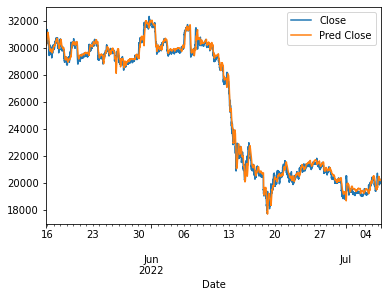

In [9]:
df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period =  +1)
df_preds_true.dropna().plot()
df_preds_true.dropna()

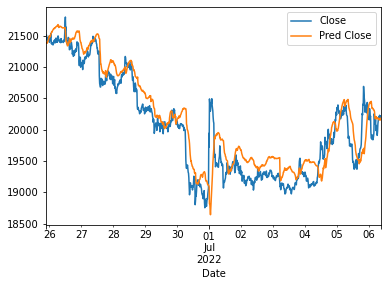

In [10]:
df_preds_true.iloc[-new_time_steps:].dropna().plot()


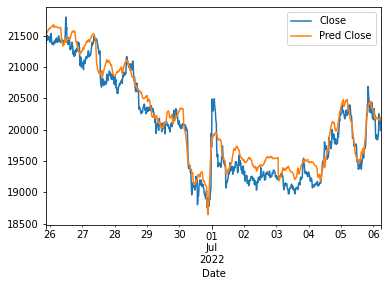

In [11]:
df_preds_shifted_true = tu.merge_true_preds(can_btc.candles, preds, period=-15+1)
df_preds_shifted_true.iloc[-new_time_steps:].dropna().plot()


Initial time 2022-06-25 22:45:00
Final time 2022-07-06 10:15:00
Fee: 0.025
----------------------
Buy      613 ( 356 ok 257 ko )
Avg PCT gain: 1.0022697895195827
Avg PCT loss: 0.9982277365001945
Wins  PCT   0.5807504078303426
Avg PCT Gain.    1.0022697895195827
No-op    0
Wallet   6342.2807500000035
Drawback -277.98000000000076
Kelly Fraction    0.1631916070001298
Total earned 6342.2807500000035


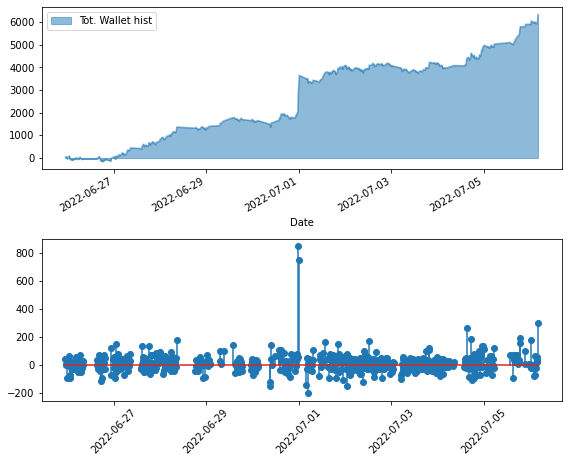

In [40]:
wallet_hist_df, wallet, kelly_frac = s2b.backtest_df(df_preds_true.iloc[-new_time_steps:].dropna(), step_back=+ 20,
                                                    long_short = "long", fee=0.025, cutoff_long = 5. ,cutoff_short = 5.0)
s2b.show_backtest_results(wallet,wallet_hist_df)


In [13]:
def tryexceptwait(func):
  def inner(*args,**kwargs):
        try:
          return func(*args, **kwargs)
        except:
          time.sleep(61)
          return func(*args,**kwargs)
  return inner

@tryexceptwait
def getminutedata(binance_client, ticker,interval, look_back):

  frame = pd.DataFrame(binance_client.get_historical_klines(ticker,interval, look_back + "min ago UTC"))
  frame = frame.iloc[:,:6]
  frame.columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
  frame = frame.set_index("Time")
  frame.index = pd.to_datetime(frame.index,unit = "ms")
  frame = frame.astype(float)
  return frame

def print_time_status_and_sleep(prev_close_date,delta_date,dt_unit,sleep=True):

  elapsed_minutes = (pd.Timestamp(datetime.now()) -
                     prev_close_date).seconds/dt_unit
  time_condition = 1. < delta_date.seconds/dt_unit - elapsed_minutes < + 1.
  min_till_close = (delta_date.seconds/dt_unit - elapsed_minutes)
  print(f'Current Time: {pd.Timestamp(datetime.now())}')
  print(f'Minutes till Next Close: {min_till_close}')
  if sleep:
    print(f"Sleep for {min_till_close} mins.")
    time.sleep(min_till_close*dt_unit + 10)
    print(f"finished to sleep at {pd.Timestamp(datetime.now())}")


non_decimal = re.compile(r'[^\d.]+')
n_klines = crypto.kline_size
n_klines = non_decimal.sub('',n_klines)

#example: 
# a='123.f.'
# non_decimal.sub('', a )
# a='123'


In [14]:
crypto_test.binance_client.get_account()

{'makerCommission': 0,
 'takerCommission': 0,
 'buyerCommission': 0,
 'sellerCommission': 0,
 'canTrade': True,
 'canWithdraw': False,
 'canDeposit': False,
 'updateTime': 1657096129367,
 'accountType': 'SPOT',
 'balances': [{'asset': 'BNB',
   'free': '1000.00000000',
   'locked': '0.00000000'},
  {'asset': 'BTC', 'free': '1.00000000', 'locked': '0.00000000'},
  {'asset': 'BUSD', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'ETH', 'free': '100.00000000', 'locked': '0.00000000'},
  {'asset': 'LTC', 'free': '500.00000000', 'locked': '0.00000000'},
  {'asset': 'TRX', 'free': '500000.00000000', 'locked': '0.00000000'},
  {'asset': 'USDT', 'free': '10000.00000000', 'locked': '0.00000000'},
  {'asset': 'XRP', 'free': '50000.00000000', 'locked': '0.00000000'}],
 'permissions': ['SPOT']}

In [41]:
# print(
#     f'Current limit is {buyprice*(1+avg_change)} or close position in {str(time_until_close)}')
# print(
#     f'Current stop is {buyprice*(1-avg_change)} or close position in {str(time_until_close)}')

investment = 1000.
conservative_kelly = kelly_frac*.5
portfolio = investment
open_position = False
avg_change = 0.004
fee = 0.025
step_back = 20
cutoff_long = 5.

verbose = True

total_wallet_history = []
single_wallet_history = []
time_history = []
fill_order_history = []
time_fill_order_history = []
close_order_history = []

wallet = 0.
buys_cnt = 0
buys_cnt_win = 0
buys_cnt_losses = 0
drawback = 0
old_profit_negative = False
old_profits = 0
mean_pct_gain = 0
mean_pct_loss = 0

last_dates = getminutedata(
    crypto.binance_client, tickers[0], crypto.kline_size, '30').index
delta_date = last_dates[-1]-last_dates[-2]
prev_close_date = last_dates[-1]
buffer_delta = 0.1*delta_date

while True:
 
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep = True)
    ldata_df_new = crypto.load_cryptos(tickers,save = False)
    can_btc = fb.Candles(ldata_df_new,"Bitcoin")
    can_btc.buildfeatures()
    ts_btc = c2t.Candle2TimeSeries(can_btc.candles, laststeps = 2000, step_back = 48, candle_step_str = crypto.kline_size,
                    lownorm = 0.2, upnorm= 0.8)

    ts_btc.candles2ts(verbose = False)
    ts_btc.x_candles = np.asarray(ts_btc.x_candles, dtype=np.float32)
    ts_btc.x_time = np.asarray(ts_btc.x_time, dtype=np.float32)
    initial_timestamp = pd.Timestamp(datetime.strptime(PRESAVED_MODELDATE, '%y%m%d_%H_%M'))
    new_model = s2m.TimeSeries2Model(
        ts_btc.x_candles, ts_btc.x_time, ts_btc.y, ts_btc.scaler, split_fraction=1)
    new_model.sats2model()
    new_model.model = loaded_model.model
    new_model.sats2pred(predict_on_test=False)
    new_model.scaler = loaded_model.scaler
    new_preds = c2t.denorm(new_model.scaler, can_btc.candles, new_model.preds) 
    df_preds_true = tu.merge_true_preds(can_btc.candles,preds,period = +1)
    df_preds_true_shifted = df_preds_true.copy()
    df_preds_true_shifted.iloc[:,0] = df_preds_true.iloc[:,0].shift(step_back,delta_date)
    prev_true_close = df_preds_true_shifted.iloc[-2,0]
    pred_close = df_preds_true_shifted.iloc[-1,1]
    prev_close_date = ldata_df_new["Date"].iloc[-1]
    print_time_status_and_sleep(prev_close_date, delta_date, crypto.dt,sleep=False)

    if open_position == False :

        if prev_true_close*(1+fee/cutoff_long) < pred_close:

            dff = getminutedata(crypto.binance_client, tickers[0],'1m','120')
            buy_quantity = round(portfolio*conservative_kelly / float(dff['Close'].iloc[-1]))
            buy_quantity = 0.001

            balances = crypto_test.binance_client.get_account()['balances']
            balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
            balance_before_open = balances_dict["USDT"]

            order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                        side='BUY',
                                                        type='MARKET',
                                                        quantity= buy_quantity)
                                                        
            order_time = pd.Timestamp(datetime.now())
            est_close_time = df_preds_true_shifted.index[-1]
            open_position = True
            filled_open_price = float(order['fills'][0]['price'])

            print('-----------------------------------')
            print(f'Order filled at {str(order_time)}')
            print(f'Order will be closed around {str(est_close_time)}')
            print(f'Filled open price: {filled_open_price}')
            print(f'Previous close price: {prev_true_close}')
            print(f'Predicted close price: {pred_close}')

            while open_position :

                time.sleep(60)
                dff = getminutedata(crypto.binance_client, tickers[0],'1m','2')
                current_price = dff["Close"].iloc[-1]
                current_time = pd.Timestamp(datetime.now())
                time_until_close = (est_close_time - current_time - buffer_delta )

                if verbose:
                    print('--------------------------------')
                    print(f'Current price: {current_price}')
                    print(f'Current time: {current_time}')
                    print(f'Time until close of position: {time_until_close} mins.')
                    print(f'Position will be closed at {time_until_close + current_time}')
                
                if (time_until_close.seconds/crypto.dt) < 1 :

                    order = crypto_test.binance_client.create_order(symbol=tickers[0],
                                                                side='SELL',
                                                                type='MARKET',
                                                                quantity= buy_quantity)  
                    open_position = False
                    filled_close_price = float(order['fills'][0]['price'])
                    order_close_time = pd.Timestamp(datetime.now())

                    balances = crypto_test.binance_client.get_account()['balances']
                    balances_dict = {balances[i]["asset"]: float(balances[i]["free"]) for i in 
                            range(len(balances)) if balances[i]["asset"] in tickers[0]}
                    balance_after_close = balances_dict["USDT"]
                    profit = balance_after_close - balance_before_open
                    wallet += profit
                    total_wallet_history.append(wallet)
                    single_wallet_history.append(profit)
                    time_history.append(order_close_time)
                    buys_cnt += 1

                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Filled open price: {filled_open_price}')
                    print(f'Filled close price: {filled_close_price}')
                    print(f'Position closed at {str(order_close_time)}')
                    print(f'Profit: {profit}')
                    prev_close_date = getminutedata(crypto.binance_client, tickers[0], crypto.kline_size, n_klines).index[-1]
                
                    if profit > 0:
                        buys_cnt_win += 1
                        old_profit_negative = False
                        mean_pct_gain += filled_close_price / filled_open_price
                    else:
                        buys_cnt_losses += 1
                        mean_pct_loss += filled_close_price / filled_open_price
                        if old_profit_negative:
                            old_profits += profit
                        else:
                            old_profits = profit
                        if old_profits < drawback:
                            drawback = old_profits
                        old_profit_negative = True                    
        else:
            old_profit_negative = False
            old_profits = 0
            dff = getminutedata(
                crypto.binance_client, tickers[0], crypto.kline_size, n_klines)
            prev_close_date = dff.index[-1]
            print(f'Order not filled')
            print(f'Previous true close with fee: {prev_true_close*(1+fee/cutoff_long)}')
            print(f'Predicted close: {pred_close}')
            
        wallet_hist_df = pd.DataFrame(
            np.array([total_wallet_history, single_wallet_history]).T,
            index=pd.Series(time_history, name="Date"),
            columns=["Tot. Wallet hist", "Single Wallet hist"],
        )
        display(wallet_hist_df)
        wallet_hist_df.to_csv(dir_to_save + "/live_wallet_history.csv")

Current Time: 2022-07-06 10:36:16.314559
Minutes till Next Close: 8.733333333333334
Sleep for 8.733333333333334 mins.
finished to sleep at 2022-07-06 10:45:10.328156
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 10:45:24.718899
Minutes till Next Close: 14.6
-----------------------------------
Order filled at 2022-07-06 10:45:27.284204
Order will be closed around 2022-07-06 11:00:00
Filled open price: 20109.28
Previous close price: 20048.08
Predicted close price: 20197.446213912957
--------------------------------
Current price: 20124.18
Current time: 2022-07-06 10:46:27.972950
Time until close of position: 0 days 00:12:02.027050 mins.
Position will be closed at 2022-07-06 10:58:30
--------------------------------
Current price: 20137.61
Current time: 2022-07-06 10:47:28.469810
Time until close of position: 0 days 00:11:01.530190 mins.
Position wil

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.0047,0.0047


Current Time: 2022-07-06 10:57:38.531972
Minutes till Next Close: 2.366666666666667
Sleep for 2.366666666666667 mins.
finished to sleep at 2022-07-06 11:00:10.536111
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 11:00:26.430639
Minutes till Next Close: 14.566666666666666
-----------------------------------
Order filled at 2022-07-06 11:00:28.445315
Order will be closed around 2022-07-06 11:15:00
Filled open price: 20130.29
Previous close price: 20049.99
Predicted close price: 20197.446213912957
--------------------------------
Current price: 20125.36
Current time: 2022-07-06 11:01:28.985958
Time until close of position: 0 days 00:12:01.014042 mins.
Position will be closed at 2022-07-06 11:13:30
--------------------------------
Current price: 20119.56
Current time: 2022-07-06 11:02:29.573686
Time until close of position: 0 days 00:11:00.426314 mins

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205


Current Time: 2022-07-06 11:12:38.609264
Minutes till Next Close: 2.366666666666667
Sleep for 2.366666666666667 mins.
finished to sleep at 2022-07-06 11:15:10.616000
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 11:15:22.597445
Minutes till Next Close: 14.633333333333333
-----------------------------------
Order filled at 2022-07-06 11:15:24.836099
Order will be closed around 2022-07-06 11:30:00
Filled open price: 20083.93
Previous close price: 19909.69
Predicted close price: 20197.446213912957
--------------------------------
Current price: 20074.65
Current time: 2022-07-06 11:16:26.019870
Time until close of position: 0 days 00:12:03.980130 mins.
Position will be closed at 2022-07-06 11:28:30
--------------------------------
Current price: 20054.6
Current time: 2022-07-06 11:17:26.678554
Time until close of position: 0 days 00:11:03.321446 mins.

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850


Current Time: 2022-07-06 11:27:35.340276
Minutes till Next Close: 2.416666666666666
Sleep for 2.416666666666666 mins.
finished to sleep at 2022-07-06 11:30:10.349582
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 11:30:23.483352
Minutes till Next Close: 14.616666666666667
-----------------------------------
Order filled at 2022-07-06 11:30:25.740007
Order will be closed around 2022-07-06 11:45:00
Filled open price: 20076.48
Previous close price: 19972.62
Predicted close price: 20197.446213912957
--------------------------------
Current price: 20059.18
Current time: 2022-07-06 11:31:26.340701
Time until close of position: 0 days 00:12:03.659299 mins.
Position will be closed at 2022-07-06 11:43:30
--------------------------------
Current price: 20067.76
Current time: 2022-07-06 11:32:27.156350
Time until close of position: 0 days 00:11:02.843650 mins

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490


Current Time: 2022-07-06 11:42:36.583467
Minutes till Next Close: 2.4000000000000004
Sleep for 2.4000000000000004 mins.
finished to sleep at 2022-07-06 11:45:10.584023
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 11:45:22.987701
Minutes till Next Close: 14.633333333333333
-----------------------------------
Order filled at 2022-07-06 11:45:25.407101
Order will be closed around 2022-07-06 12:00:00
Filled open price: 20121.49
Previous close price: 20089.67
Predicted close price: 20197.446213912957
--------------------------------
Current price: 20108.72
Current time: 2022-07-06 11:46:26.069624
Time until close of position: 0 days 00:12:03.930376 mins.
Position will be closed at 2022-07-06 11:58:30
--------------------------------
Current price: 20096.44
Current time: 2022-07-06 11:47:26.652128
Time until close of position: 0 days 00:11:03.347872 mi

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 11:57:37.210121
Minutes till Next Close: 2.383333333333333
Sleep for 2.383333333333333 mins.
finished to sleep at 2022-07-06 12:00:10.219771
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 12:00:24.761185
Minutes till Next Close: 14.6
Order not filled
Previous true close with fee: 20240.750249999997
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 12:00:25.322000
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 12:15:10.337035
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 12:15:25.772587
Minutes till Next Close: 14.583333333333334
Order not filled
Previous true close with fee: 20291.341949999998
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 12:15:26.348109
Minutes till Next Close: 14.566666666666666
Sleep for 14.566666666666666 mins.
finished to sleep at 2022-07-06 12:30:10.357046
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 12:30:27.359946
Minutes till Next Close: 14.55
Order not filled
Previous true close with fee: 20306.869199999997
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 12:30:27.860245
Minutes till Next Close: 14.55
Sleep for 14.55 mins.
finished to sleep at 2022-07-06 12:45:10.866977
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 12:45:25.154890
Minutes till Next Close: 14.583333333333334
Order not filled
Previous true close with fee: 20263.0311
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 12:45:25.858745
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 13:00:10.884839
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 13:00:24.873480
Minutes till Next Close: 14.6
Order not filled
Previous true close with fee: 20331.501749999996
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 13:00:25.481270
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 13:15:10.490097
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 13:15:25.143996
Minutes till Next Close: 14.583333333333334
Order not filled
Previous true close with fee: 20315.532299999995
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 13:15:25.718163
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 13:30:10.797450
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 13:30:25.310685
Minutes till Next Close: 14.583333333333334
Order not filled
Previous true close with fee: 20319.763349999997
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 13:30:26.543855
Minutes till Next Close: 14.566666666666666
Sleep for 14.566666666666666 mins.
finished to sleep at 2022-07-06 13:45:10.568755
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 13:45:25.312627
Minutes till Next Close: 14.583333333333334
Order not filled
Previous true close with fee: 20285.49285
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 13:45:25.860620
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 14:00:10.885274
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 14:00:24.225275
Minutes till Next Close: 14.6
Order not filled
Previous true close with fee: 20263.24215
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 14:00:24.859769
Minutes till Next Close: 14.6
Sleep for 14.6 mins.
finished to sleep at 2022-07-06 14:15:10.860595
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 14:15:24.039795
Minutes till Next Close: 14.6
Order not filled
Previous true close with fee: 20336.9187
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 14:15:24.699757
Minutes till Next Close: 14.6
Sleep for 14.6 mins.
finished to sleep at 2022-07-06 14:30:10.712756
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 14:30:24.852334
Minutes till Next Close: 14.6
Order not filled
Previous true close with fee: 20313.813749999998
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 14:30:25.526233
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 14:45:10.546330
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 14:45:23.088505
Minutes till Next Close: 14.616666666666667
Order not filled
Previous true close with fee: 20303.76375
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 14:45:23.565967
Minutes till Next Close: 14.616666666666667
Sleep for 14.616666666666667 mins.
finished to sleep at 2022-07-06 15:00:10.578867
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 15:00:27.544383
Minutes till Next Close: 14.55
Order not filled
Previous true close with fee: 20250.106799999998
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 15:00:28.476750
Minutes till Next Close: 14.533333333333333
Sleep for 14.533333333333333 mins.
finished to sleep at 2022-07-06 15:15:10.520484
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 15:15:25.198171
Minutes till Next Close: 14.583333333333334
Order not filled
Previous true close with fee: 20276.80965
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 15:15:25.686682
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 15:30:10.703444
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 15:30:26.201058
Minutes till Next Close: 14.566666666666666
Order not filled
Previous true close with fee: 20232.7002
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 15:30:26.682344
Minutes till Next Close: 14.566666666666666
Sleep for 14.566666666666666 mins.
finished to sleep at 2022-07-06 15:45:10.718657
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 15:45:23.624430
Minutes till Next Close: 14.616666666666667
Order not filled
Previous true close with fee: 20233.65495
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144


Current Time: 2022-07-06 15:45:24.107844
Minutes till Next Close: 14.6
Sleep for 14.6 mins.
finished to sleep at 2022-07-06 16:00:10.125893
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 16:00:23.459753
Minutes till Next Close: 14.616666666666667
-----------------------------------
Order filled at 2022-07-06 16:00:25.743321
Order will be closed around 2022-07-06 16:15:00
Filled open price: 20148.48
Previous close price: 20092.26
Predicted close price: 20197.446213912957
--------------------------------
Current price: 20140.93
Current time: 2022-07-06 16:01:26.216871
Time until close of position: 0 days 00:12:03.783129 mins.
Position will be closed at 2022-07-06 16:13:30
--------------------------------
Current price: 20160.98
Current time: 2022-07-06 16:02:26.818495
Time until close of position: 0 days 00:11:03.181505 mins.
Position will be closed 

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144
2022-07-06 16:12:33.128183,0.00072,0.01311


Current Time: 2022-07-06 16:12:34.430679
Minutes till Next Close: 2.4333333333333336
Sleep for 2.4333333333333336 mins.
finished to sleep at 2022-07-06 16:15:10.435058
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 16:15:26.013466
Minutes till Next Close: 14.566666666666666
-----------------------------------
Order filled at 2022-07-06 16:15:28.119874
Order will be closed around 2022-07-06 16:30:00
Filled open price: 20187.76
Previous close price: 20081.13
Predicted close price: 20197.446213912957
--------------------------------
Current price: 20185.66
Current time: 2022-07-06 16:16:28.585795
Time until close of position: 0 days 00:12:01.414205 mins.
Position will be closed at 2022-07-06 16:28:30
--------------------------------
Current price: 20178.0
Current time: 2022-07-06 16:17:29.251418
Time until close of position: 0 days 00:11:00.748582 min

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144
2022-07-06 16:12:33.128183,0.00072,0.01311
2022-07-06 16:27:35.289764,-0.00374,-0.00446


Current Time: 2022-07-06 16:27:36.526580
Minutes till Next Close: 2.4000000000000004
Sleep for 2.4000000000000004 mins.
finished to sleep at 2022-07-06 16:30:10.531137
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 16:30:25.456346
Minutes till Next Close: 14.583333333333334
Order not filled
Previous true close with fee: 20234.810699999998
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144
2022-07-06 16:12:33.128183,0.00072,0.01311
2022-07-06 16:27:35.289764,-0.00374,-0.00446


Current Time: 2022-07-06 16:30:25.988731
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 16:45:10.993209
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 16:45:24.140429
Minutes till Next Close: 14.6
Order not filled
Previous true close with fee: 20203.94715
Predicted close: 20197.446213912957


,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144
2022-07-06 16:12:33.128183,0.00072,0.01311
2022-07-06 16:27:35.289764,-0.00374,-0.00446


Current Time: 2022-07-06 16:45:25.278905
Minutes till Next Close: 14.583333333333334
Sleep for 14.583333333333334 mins.
finished to sleep at 2022-07-06 17:00:10.337797
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 17:00:23.663227
Minutes till Next Close: 14.616666666666667
-----------------------------------
Order filled at 2022-07-06 17:00:26.235217
Order will be closed around 2022-07-06 17:15:00
Filled open price: 20318.96
Previous close price: 19999.38
Predicted close price: 20197.446213912957
--------------------------------
Current price: 20348.97
Current time: 2022-07-06 17:01:26.760546
Time until close of position: 0 days 00:12:03.239454 mins.
Position will be closed at 2022-07-06 17:13:30
--------------------------------
Current price: 20333.15
Current time: 2022-07-06 17:02:27.330136
Time until close of position: 0 days 00:11:02.669864 mi

,Tot. Wallet hist,Single Wallet hist
Date,,
2022-07-06 10:57:37.005365,0.00470,0.00470
2022-07-06 11:12:37.283957,-0.01735,-0.02205
2022-07-06 11:27:33.236186,-0.03585,-0.01850
2022-07-06 11:42:34.639634,-0.00095,0.03490
2022-07-06 11:57:35.640966,-0.01239,-0.01144
2022-07-06 16:12:33.128183,0.00072,0.01311
2022-07-06 16:27:35.289764,-0.00374,-0.00446
2022-07-06 17:12:33.844801,-0.01258,-0.00884


Current Time: 2022-07-06 17:12:35.284839
Minutes till Next Close: 2.416666666666666
Sleep for 2.416666666666666 mins.
finished to sleep at 2022-07-06 17:15:10.290232
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Current Time: 2022-07-06 17:15:24.916918
Minutes till Next Close: 14.6
-----------------------------------
Order filled at 2022-07-06 17:15:26.949149
Order will be closed around 2022-07-06 17:30:00
Filled open price: 20297.26
Previous close price: 20067.7
Predicted close price: 20197.446213912957


KeyboardInterrupt: 

In [ ]:
wall_hist = pd.read_csv(dir_to_save + "/live_wallet_history.csv", index_col=0)
wall_hist.index = pd.to_datetime(wall_hist.index)
wall_hist


### Try with Long Short Strategy here. First write functions to make code a bit shorter

In [ ]:
def get_balance(crypto,ticker):

    balance = crypto.binance_client.get_account()['balances']
    balance_dict = {balance[i]["asset"]: float(balance[i]["free"]) for i in
                 range(len(balances)) if balance[i]["asset"] in ticker}
    balance_cash = balances_dict["USDT"]
    return balance_cash


In [ ]:
def create_order_util(crypto, order_side, enter_or_exit, ticker, investment, kelly_frac):

    if order_side != "BUY" and order_side != "SELL":
        raise ValueError("order_side can only be BUY or SELL")
    
    if enter_or_exit != "enter" and enter_or_exit != "exit":
        raise ValueError("enter_or_exit can only be enter or exit")

    dff = getminutedata(crypto.binance_client,ticker,"1m",120)
    buy_quantity = round(investment*kelly_frac / float(dff['Close'].iloc[-1]))
    buy_quantity = 0.001

    balance_before_order = get_balance(crypto, ticker)

    order = crypto.binance_client.create_order(symbol=tickers[0],
                                                side=order_side,
                                                type='MARKET',
                                                quantity=buy_quantity)
    
    balance_after_order = get_balance(crypto, ticker)

    if order_side == "BUY" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "SELL" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order
    elif order_side == "SELL" and enter_or_exit == "enter":
        open_position = True
        balance_cash = balance_before_order
    elif order_side == "BUY" and enter_or_exit == "exit":
        open_position = False
        balance_cash = balance_after_order

    order_time = pd.Timestamp(datetime.now())
    filled_price = float(order['fills'][0]['price'])

    return open_position, order, order_time, filled_price, balance_cash

# est_close_time = df_preds_true_shifted.index[-1]
# ticker = tickers[0]
# order_side = "SELL"
# client = crypto
#open_position, order, order_time, filled_open_price, balance_before_open = create_order_util(crypto, order_side, ticker, investment, kelly_frac)

def check_position_util(crypto,est_close_time,buffer_delta,verbose = False):

    time.sleep(60)
    dff = getminutedata(crypto.binance_client,ticker, '1m', '2')                
    current_price = dff["Close"].iloc[-1]
    current_time = pd.Timestamp(datetime.now())
    time_until_close = (est_close_time - current_time - buffer_delta)

    if verbose:
        print('--------------------------------')
        print(f'Current price: {current_price}')
        print(f'Current time: {current_time}')
        print(f'Time until close of position: {time_until_close} mins.')
        print(f'Position will be closed at {time_until_close + current_time}')

    return current_price, current_time, time_until_close

#current_price, current_time, time_until_close = check_open_position(crypto, est_close_time, buffer_delta, verbose = True)


def pnl_after_close(balance_before, balance_after, filled_open_price):

    filled_close_price = float(order['fills'][0]['price'])
    order_close_time = pd.Timestamp(datetime.now())
    profit = balance_before - balance_after
    wallet += profit
    buys_cnt += 1

    print(f'Position closed at {str(order_close_time)}')
    print(f'Filled open price: {filled_open_price}')
    print(f'Filled close price: {filled_close_price}')
    print(f'Position closed at {str(order_close_time)}')
    print(f'Profit: {profit}')

    if profit > 0:
        buys_cnt_win += 1
        old_profit_negative = False
        mean_pct_gain += filled_close_price / filled_open_price
    else:
        buys_cnt_losses += 1
        mean_pct_loss += filled_close_price / filled_open_price
        if old_profit_negative:
            old_profits += profit
        else:
            old_profits = profit
        if old_profits < drawback:
            drawback = old_profits
        old_profit_negative = True

    return wallet, profit, order_close_time

#wallet, profit, order_close_time, open_position = close_position_util(crypto, crypto_test, order_side, quantity_to_close)
#                    
#total_wallet_history.append(wallet)
#single_wallet_history.append(profit)
#time_history.append(order_close_time)
